In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F


class CBOW(nn.Module):

    def __init__(self, context_size=2, embedding_size=100, vocab_size=None):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear1 = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=1)
        out = self.linear1(embeds)
        return out


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


In [80]:
def train(tokenized_words, epochs=100, context_size=2, embedding_size=10):
    """
    context_size: x words to the left, 2 to the right
    """
    vocab = set(tokenized_words)
    vocab_size = len(vocab)

    word_to_ix = {word: i for i, word in enumerate(vocab)}
    data = []
    for i in range(2, len(tokenized_words) - 2):
        context = [tokenized_words[i - 2], tokenized_words[i - 1],
                   tokenized_words[i + 1], tokenized_words[i + 2]]
        target = tokenized_words[i]
        data.append((context, target))

    loss_func = nn.CrossEntropyLoss()
    
    net = CBOW(context_size, embedding_size=embedding_size, vocab_size=vocab_size)
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    
    print("Start training...")
    for epoch in range(epochs):
        total_loss = 0
        BSZ = 64
        input_batch = []
        target_batch = []
        n_batches = 0
        for context, target in data:
            context_var = make_context_vector(context, word_to_ix)
            target_ = torch.LongTensor([word_to_ix[target]])
            # Build batches
            input_batch.append(context_var)
            target_batch.append(target_)
            if len(input_batch) == BSZ:
                # Run completed batch
                input_batch = torch.stack(input_batch)
                target_batch = torch.stack(target_batch).long().squeeze()

                net.zero_grad()
                log_probs = net(input_batch)
                loss = loss_func(log_probs, target_batch)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                
                input_batch = []
                target_batch = []
                n_batches += 1
        print(epoch, total_loss)
    
    return net, vocab, word_to_ix

In [113]:
from ptb import lang_util

PTB_TRAIN_PATH = "/Users/jgordon/nta/datasets/PTB/ptb.train.txt"

def tokenize(path):
    """Tokenizes a text file."""
    assert os.path.exists(path)
    all_words = []
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            words = line.split() + ["<eos>"]
            all_words.extend(words)
    return all_words

tokenized_words = tokenize(PTB_TRAIN_PATH)


In [ ]:
ESIZE = 100
net, vocab, word_to_ix = train(tokenized_words, embedding_size=ESIZE, epochs=10)

filename = 'ptb_word2vec_%d.pt' % 100
torch.save(net.embeddings.weight, filename)
print("Saving %s, size: %s" % (filename, net.embeddings.weight.size()))

## FastText

In [131]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embedding(embeddings):

    fig, ax = plt.subplots(dpi=300)

    plot_words = ['dog', 'cat', 'fish', 'cheese', 'bread', 
                  'colorado', 'travel', 'california', 'texas', 'apple',
                  'nevada', 'mississippi', "'s", "n't", "a", "the", "in", "to",
                  'lawsuit', 'legal', 'finance', 'financial', 
                  'money', 'currency', 'dollars', 'man', 'woman', 'boy', 'girl',
                 'orange', 'institution', 'bank', 'donation', 'investment']
    word_embeddings = []
    found_words = []
    for word in plot_words:
        if word in embeddings:
            word_embeddings.append(embeddings[word])
            found_words.append(word)
    word_embeddings = np.array(word_embeddings)
    print(word_embeddings.shape)
    pca = PCA(n_components=2)
    embed_pca = pca.fit_transform(word_embeddings)

    X = []
    Y = []

    for i, word in enumerate(found_words):
        x, y = embed_pca[i, :]
        X.append(x)
        Y.append(y)
        ax.text(x+0.03, y+0.03, word, fontsize=5)

    ax.scatter(X, Y, s=1.0, alpha=0.5)
    plt.show()


In [133]:
import fasttext

model = fasttext.train_unsupervised(PTB_TRAIN_PATH, model='skipgram')
filename = "ptb_fasttext.bin"
print("Saved %s" % filename)
model.save_model(filename)

Saved ptb_fasttext.bin


(32, 100)


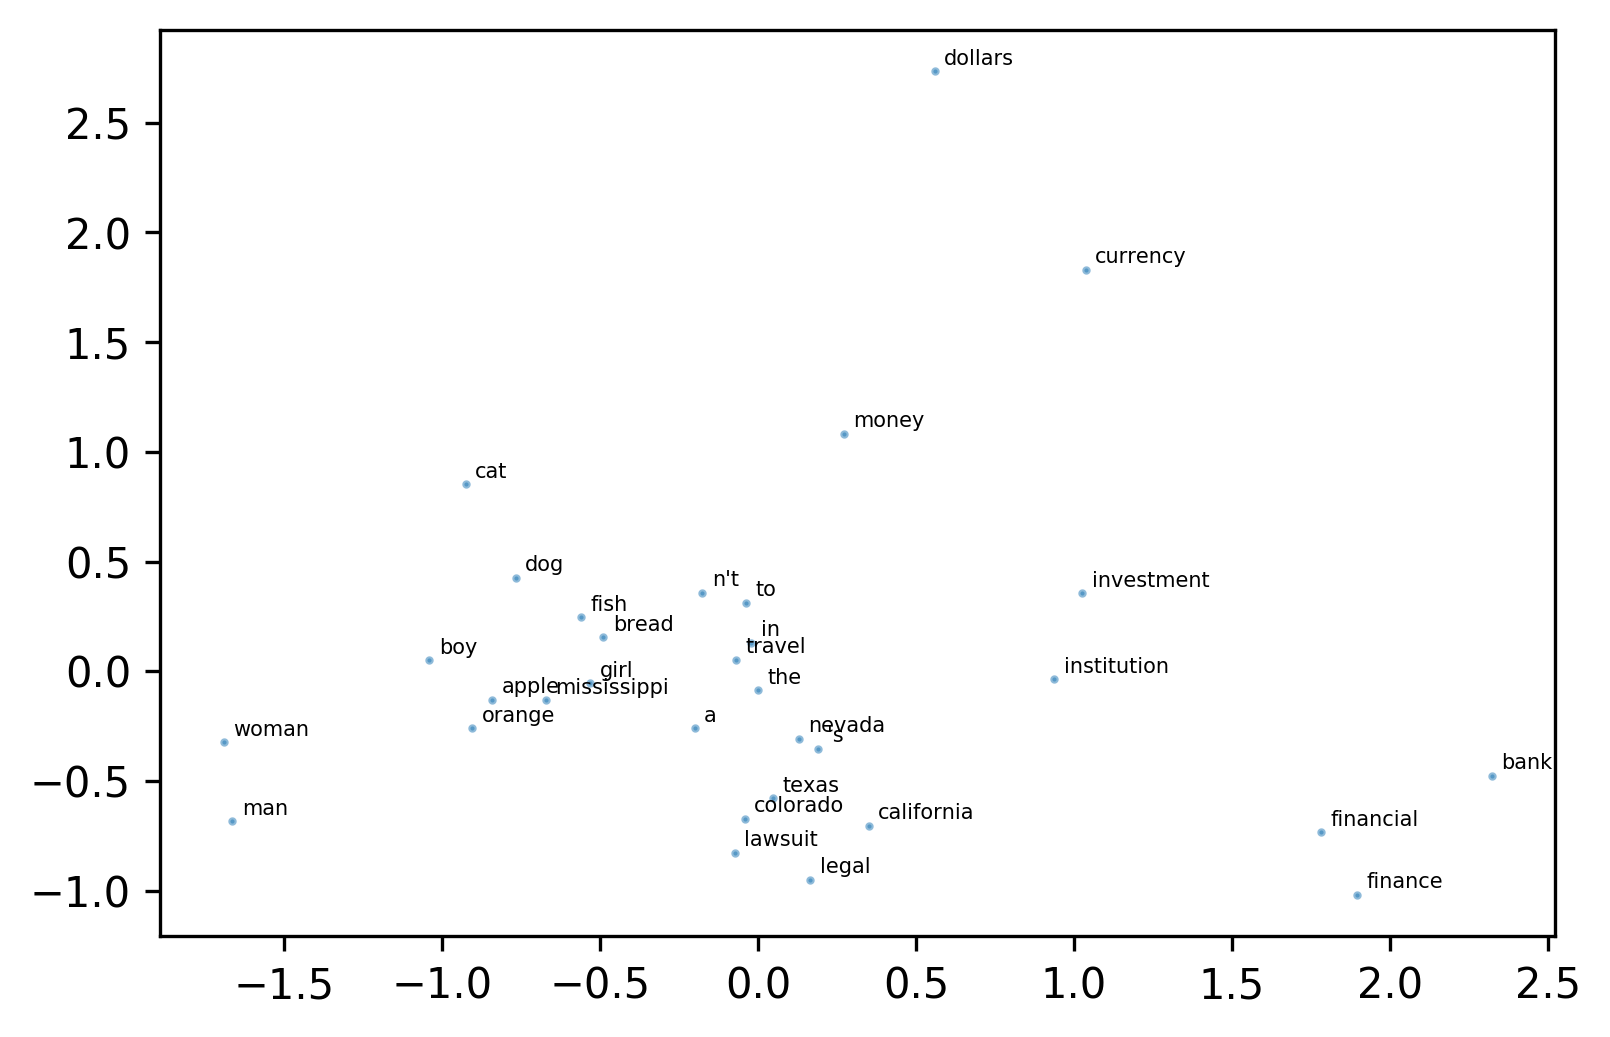

In [132]:
visualize_embedding(model)

In [3]:
from ptb import lang_util
import fasttext

# corpus = lang_util.Corpus("/Users/jgordon/nta/datasets/PTB")
ft_model = fasttext.load_model("/Users/jgordon/nta/datasets/embeddings/ptb_fasttext.bin")


In [15]:
len(ft_model.get_words())

10000

-1.6982269 1.4514699


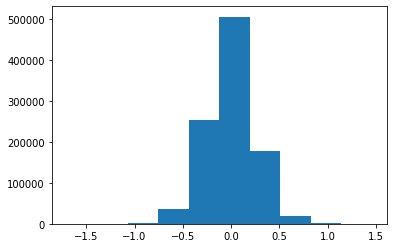

In [8]:
import torch
import matplotlib.pyplot as plt

all_vals = []
i = 0
for word in ft_model.get_words():
    all_vals.extend(ft_model[word])
    if i > 100:
        break

print(min(all_vals), max(all_vals))

plt.hist(all_vals)
plt.show()

In [ ]:
embedding = {}
for word_id, word in enumerate(corpus.dictionary.idx2word):
    embedded = ft_model[word]
    embedding[word_id] = torch.tensor(embedded)
